In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load Data ---
try:
    df = pd.read_csv('data/MarketFarePredictionData.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'MarketFarePredictionData.csv' not found. Please run the preprocessing script first.")
    exit()

Dataset loaded successfully.


In [2]:
# --- 2. Define Features and Target ---
features = ['NonStopMiles', 'MktMilesFlown', 'Market_HHI', 'Market_share', 'MktCoupons']
target = 'Average_Fare'

X = df[features]
y = df[target]

In [3]:
# --- 3. Create the Three-Way Split ---
# First, split into training (80%) and test (20%) sets.
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Then, split the 80% training data into a smaller training set (60% of original) and a validation set (20% of original).
# 0.25 * 0.80 = 0.20
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

print(f"Data split into: {len(X_train)} training samples, {len(X_val)} validation samples, and {len(X_test)} test samples.")

Data split into: 948766 training samples, 316256 validation samples, and 316256 test samples.


In [4]:
# --- 4. Scale the Features ---
scaler = StandardScaler()
# Fit ONLY on the training data
scaler.fit(X_train)
# Transform all three sets
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)



Optimal k found: 3 (based on validation set performance)


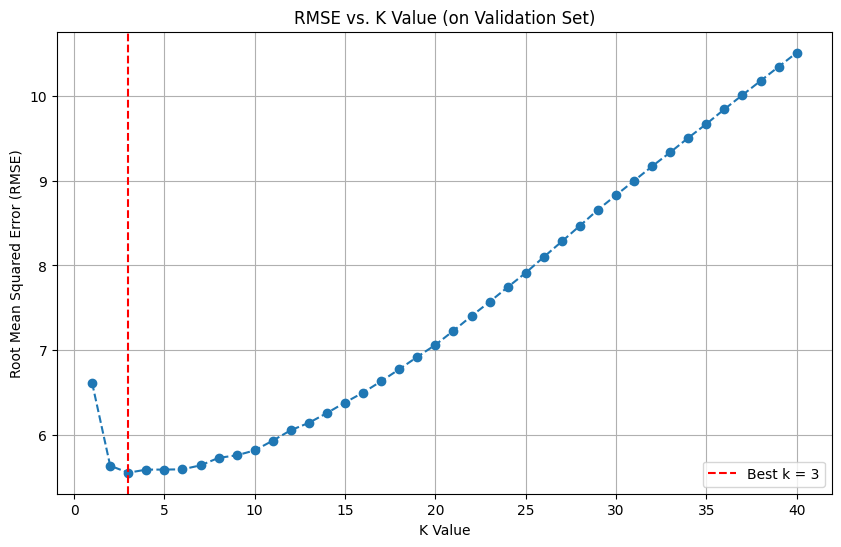

In [6]:
# --- 5. Find the Optimal 'k' using the Validation Set ---
k_range = range(1, 41)
rmse_values = []

for k in k_range:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train_scaled, y_train)
    y_val_pred = model.predict(X_val_scaled)
    error = np.sqrt(mean_squared_error(y_val, y_val_pred))
    rmse_values.append(error)

# Find the best k value
best_k = k_range[np.argmin(rmse_values)]
print(f"\nOptimal k found: {best_k} (based on validation set performance)")

# Plot the RMSE vs. K value graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, rmse_values, marker='o', linestyle='--')
plt.title('RMSE vs. K Value (on Validation Set)')
plt.xlabel('K Value')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.axvline(best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
plt.legend()
plt.grid(True)
plt.show()

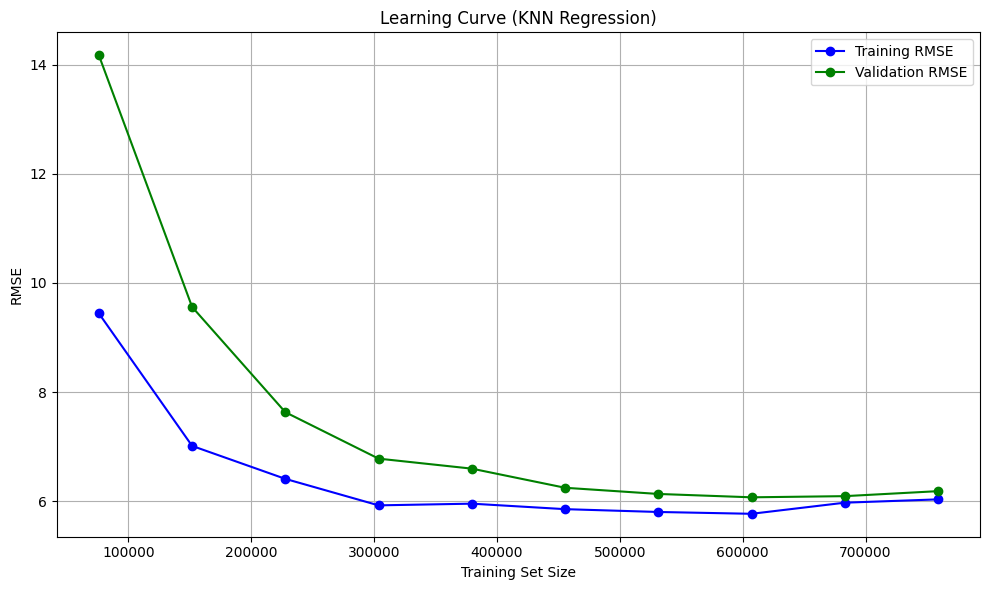

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsRegressor

# Define your KNN model (set n_neighbors to your best k)
knn = KNeighborsRegressor(n_neighbors=3)

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    knn, X_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
)

# Convert negative RMSE to positive
train_rmse = -train_scores
val_rmse = -val_scores

# Calculate mean and std
train_rmse_mean = np.mean(train_rmse, axis=1)
train_rmse_std = np.std(train_rmse, axis=1)
val_rmse_mean = np.mean(val_rmse, axis=1)
val_rmse_std = np.std(val_rmse, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmse_mean, 'o-', color='blue', label='Training RMSE')
plt.plot(train_sizes, val_rmse_mean, 'o-', color='green', label='Validation RMSE')
plt.title('Learning Curve (KNN Regression)')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# --- 6. Train the Final Model and Evaluate on the Test Set ---
# Now, we train our final model on the COMBINED training and validation data
final_model = KNeighborsRegressor(n_neighbors=best_k)

# We need to re-scale based on the full training data (train + val)
scaler_final = StandardScaler()
scaler_final.fit(X_train_full)
X_train_full_scaled = scaler_final.transform(X_train_full)
X_test_final_scaled = scaler_final.transform(X_test)

# Train the final model
start_train_time = time.time()
final_model.fit(X_train_full_scaled, y_train_full)
end_train_time = time.time()
training_time = end_train_time - start_train_time

# Make final predictions on the unseen test set
start_pred_time = time.time()
y_test_pred = final_model.predict(X_test_final_scaled)
end_pred_time = time.time()
prediction_time_total = end_pred_time - start_pred_time


--- Final Model Performance on Unseen Test Set ---
Accuracy Metrics (with k=3):
  - Root Mean Squared Error (RMSE): $5.59
  - Mean Absolute Error (MAE):      $0.35
  - R-squared (R²):                 0.994

Efficiency Metrics:
  - Training Time:                  0.393037 seconds
  - Prediction Time (per 1k rows):  0.012297 ms
------------------------------------------------------


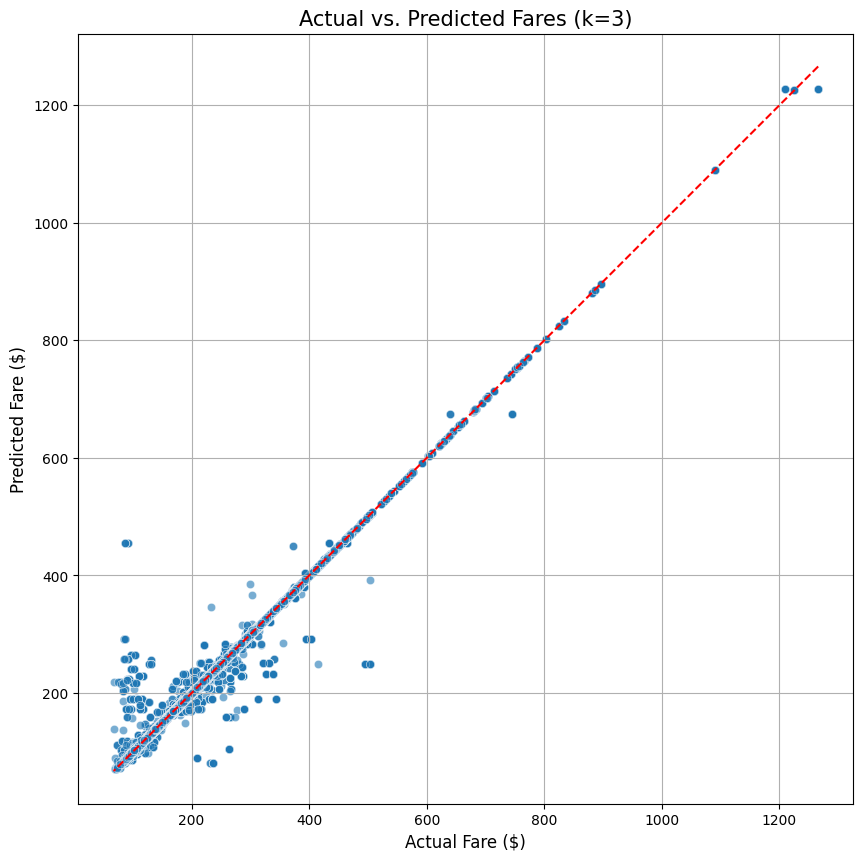

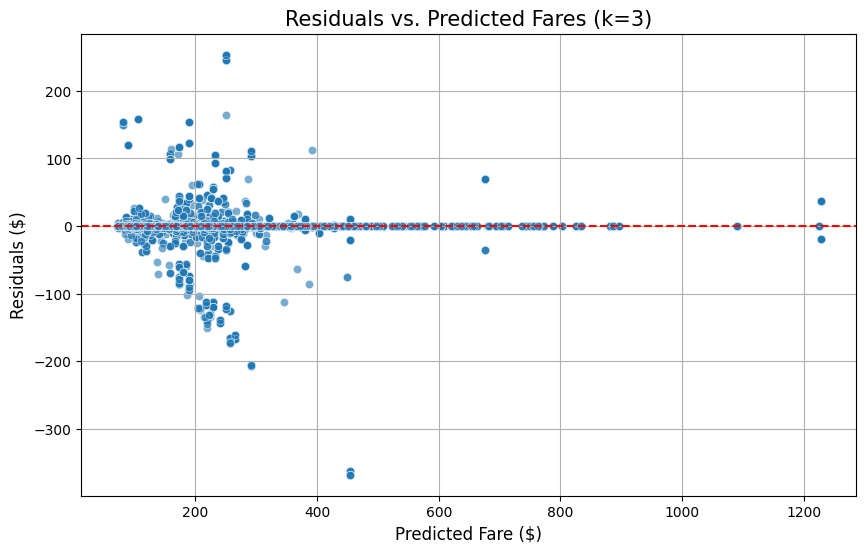

In [8]:
# --- 7. Report Final Performance Metrics ---
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
prediction_time_per_1k = (prediction_time_total / len(X_test)) * 1000

print("\n--- Final Model Performance on Unseen Test Set ---")
print(f"Accuracy Metrics (with k={best_k}):")
print(f"  - Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"  - Mean Absolute Error (MAE):      ${mae:.2f}")
print(f"  - R-squared (R²):                 {r2:.3f}")
print("\nEfficiency Metrics:")
print(f"  - Training Time:                  {training_time:.6f} seconds")
print(f"  - Prediction Time (per 1k rows):  {prediction_time_per_1k:.6f} ms")
print("------------------------------------------------------")

# --- 8. Visualize Final Results ---
# Actual vs. Predicted Fare Plot
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
p1 = max(max(y_test_pred), max(y_test))
p2 = min(min(y_test_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'r--')
plt.xlabel('Actual Fare ($)', fontsize=12)
plt.ylabel('Predicted Fare ($)', fontsize=12)
plt.title(f'Actual vs. Predicted Fares (k={best_k})', fontsize=15)
plt.axis('equal')
plt.grid(True)
plt.show()

# Residuals Plot
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_pred, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Fare ($)', fontsize=12)
plt.ylabel('Residuals ($)', fontsize=12)
plt.title(f'Residuals vs. Predicted Fares (k={best_k})', fontsize=15)
plt.grid(True)
plt.show()